In [47]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sbs
import numpy as np

spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.executer.memory", "8g")
    .getOrCreate()
)

In [48]:
path1 = '../data/tables/transactions_20210228_20210827_snapshot/'
path2 = '../data/tables/transactions_20210828_20220227_snapshot/'

In [49]:
sdf = spark.read.parquet(path1)

In [50]:
sdf = sdf.union(spark.read.parquet(path2))


In [51]:
sdf.select('order_datetime').distinct().count()

365

In [28]:
sdf

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)



In [52]:
sdf.where(F.col('dollar_value') <1500).count() / sdf.count()

0.9886481686763897

In [53]:
sdf.select('order_id').distinct().count()

8151372

In [54]:
sdf.select('merchant_abn').distinct().count()

4414

In [55]:
sdf = sdf.withColumn("is_weekend", dayofweek("order_datetime").isin([1,7]).cast("int"))\
    .withColumn("DoW", dayofweek("order_datetime").cast('int'))

In [56]:
sdf

user_id,merchant_abn,dollar_value,order_id,order_datetime,is_weekend,DoW
18478,62191208634,63.255848959735246,949a63c8-29f7-4ab...,2021-08-20,0,6
2,15549624934,130.3505283105634,6a84c3cf-612a-457...,2021-08-20,0,6
18479,64403598239,120.15860593212783,b10dcc33-e53f-425...,2021-08-20,0,6
3,60956456424,136.6785200286976,0f09c5a5-784e-447...,2021-08-20,0,6
18479,94493496784,72.96316578355305,f6c78c1a-4600-4c5...,2021-08-20,0,6
3,76819856970,448.529684285612,5ace6a24-cdf0-4aa...,2021-08-20,0,6
18479,67609108741,86.4040605836911,d0e180f0-cb06-42a...,2021-08-20,0,6
3,34096466752,301.5793450525113,6fb1ff48-24bb-4f9...,2021-08-20,0,6
18482,70501974849,68.75486276223054,8505fb33-b69a-412...,2021-08-20,0,6
4,49891706470,48.89796461900801,ed11e477-b09f-4ae...,2021-08-20,0,6


In [57]:
cleaned_sdf = sdf.withColumn('dollar_value', F.round('dollar_value', 2))

In [58]:
cleaned_sdf = cleaned_sdf.where(F.col('dollar_value') > 0)

In [85]:
log_sdf = cleaned_sdf.withColumn('log(dollar)', log(F.col('dollar_value')))

In [ ]:
log_sdf

In [ ]:
log_sdf.write.mode('overwrite').parquet("../data/curated/transaction cleaned.parquet")

In [60]:
log_cost = log_sdf.select('log(dollar)').toPandas()

In [61]:
sbs.set(rc={'figure.figsize':(11.7,8.27)})
sbs.set_style('darkgrid')
sbs.set(font_scale=1.3)

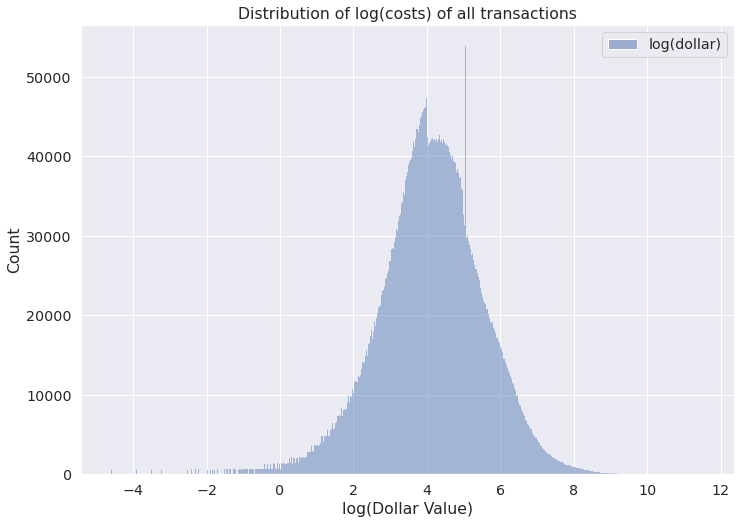

In [62]:
fig = sbs.histplot(log_cost)
fig.set_title("Distribution of log(costs) of all transactions")
fig.set_xlabel('log(Dollar Value)')
fig = fig.get_figure()
fig.savefig('../plots/Distribution of log(costs) of all transactions.png')

In [63]:
weekday_count = cleaned_sdf.groupBy('is_weekend').count().toPandas()

In [64]:
weekday_count

,is_weekend,count
0,1,2387068
1,0,5764004


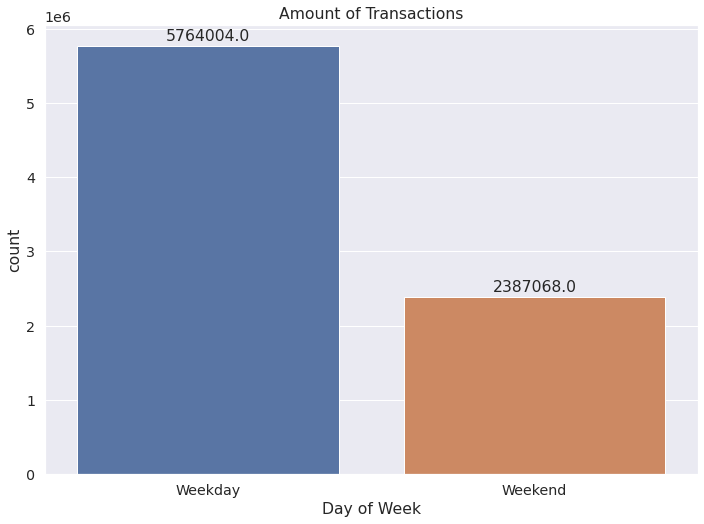

In [65]:
fig = sbs.barplot(x = 'is_weekend', y = 'count', data = weekday_count)
fig.set_xticklabels(['Weekday', 'Weekend'])
fig.set_xlabel("Day of Week")
fig.set_title("Amount of Transactions")
for p in fig.patches:
    fig.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
fig = fig.get_figure()
fig.savefig('../plots/Amount of Transactions Weekday vs Weekend.png')

In [66]:
dow_count = cleaned_sdf.groupby('DoW').count().toPandas()

In [67]:
dow_count

,DoW,count
0,1,1206874
1,6,1217477
2,5,1171158
3,7,1180194
4,2,1151880
5,4,1116557
6,3,1106932


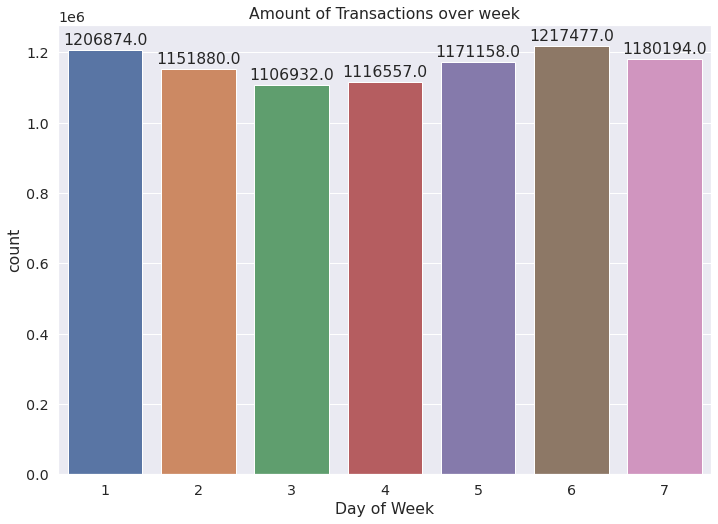

In [68]:
fig = sbs.barplot(x = 'DoW', y = 'count', data = dow_count)
fig.set_xlabel("Day of Week")
fig.set_title("Amount of Transactions over week")
for p in fig.patches:
    fig.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
fig = fig.get_figure()
fig.savefig('../plots/Amount of Transactions over week.png')

In [69]:
day_count = cleaned_sdf.groupBy('order_datetime').count().toPandas()

In [70]:
day_count

,order_datetime,count
0,2021-08-27,23199
1,2021-08-21,25124
2,2021-08-20,26240
3,2021-08-14,23879
4,2021-08-22,24109
...,...,...
360,2022-01-04,16335
361,2022-01-05,16124
362,2022-01-12,16702
363,2022-01-01,15464


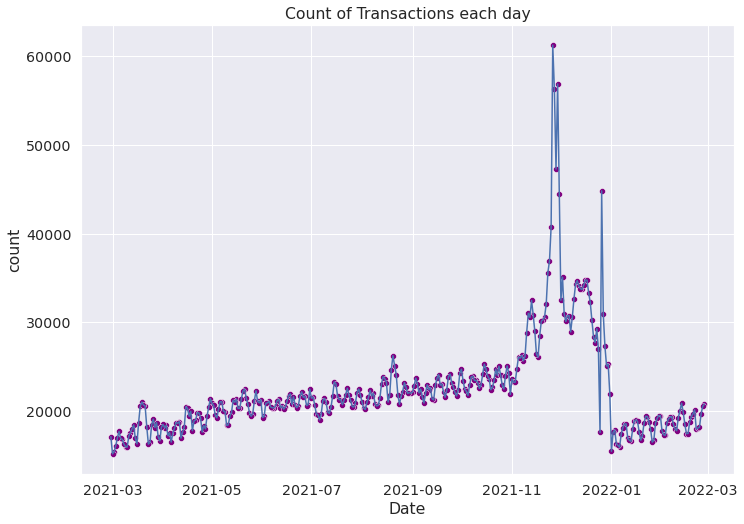

In [71]:
fig = sbs.lineplot(x = 'order_datetime', y = 'count', data = day_count)
sbs.scatterplot(x = 'order_datetime', y = 'count', data = day_count, color = 'purple')
fig.set_xlabel('Date')
fig.set_title('Count of Transactions each day')
fig = fig.get_figure()
fig.savefig('../plots/Count of Transactions each day.png')

In [72]:
dow_mean = cleaned_sdf.select('dollar_value', 'DoW').groupby('DoW').mean().toPandas()

In [73]:
dow_mean

,DoW,avg(dollar_value),avg(DoW)
0,1,166.279571,1.0
1,6,165.035713,6.0
2,5,166.931124,5.0
3,7,167.129696,7.0
4,2,166.754496,2.0
5,4,166.317369,4.0
6,3,166.065633,3.0


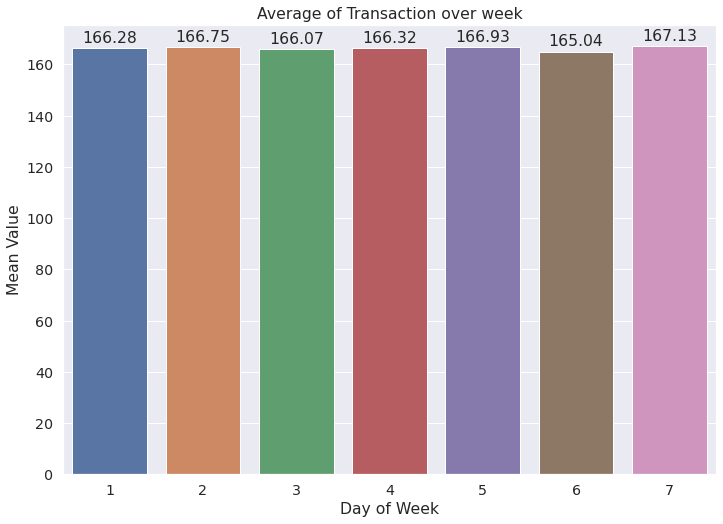

In [74]:
fig = sbs.barplot(x = 'DoW', y = 'avg(dollar_value)', data = dow_mean)
fig.set_xlabel("Day of Week")
fig.set_ylabel("Mean Value")
fig.set_title("Average of Transaction over week")
for p in fig.patches:
    fig.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
fig = fig.get_figure()
fig.savefig('../plots/Average of Transaction over week.png')

In [75]:
day_mean = cleaned_sdf.select('dollar_value', 'order_datetime').groupBy('order_datetime').mean().toPandas()

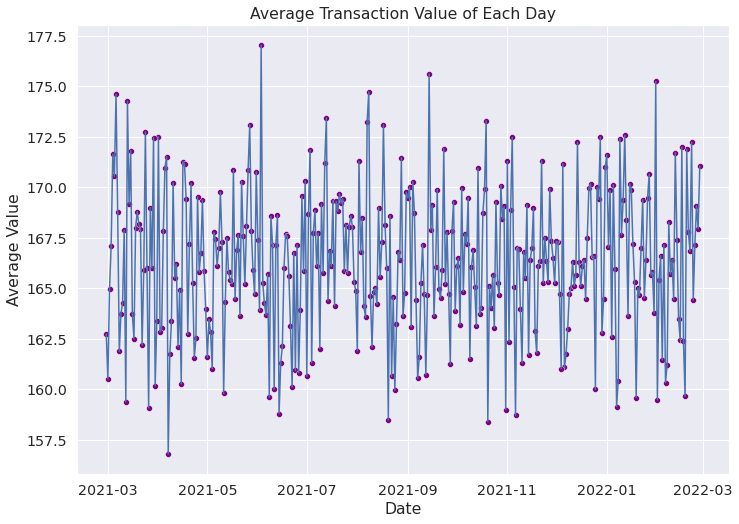

In [76]:
fig = sbs.lineplot(x = 'order_datetime', y = 'avg(dollar_value)', data = day_mean)
sbs.scatterplot(x = 'order_datetime', y = 'avg(dollar_value)', data = day_mean, color = 'purple')
fig.set_xlabel('Date')
fig.set_ylabel('Average Value')
fig.set_title("Average Transaction Value of Each Day")
fig = fig.get_figure()
fig.savefig('../plots/Average Transaction Value of Each Day.png')

In [77]:
cluster_df = cleaned_sdf \
    .groupby('merchant_abn') \
    .agg(F.expr('percentile(dollar_value, array(0.5))')[0].alias('median')) \
    .toPandas()

In [78]:
cluster_df

,merchant_abn,median
0,10023283211,187.555
1,10346855916,1532.380
2,10385163239,331.410
3,10648956813,64.480
4,10714068705,98.875
...,...,...
4409,98527912956,172.560
4410,98850646791,2938.660
4411,99009287608,141.720
4412,99420575685,2397.185


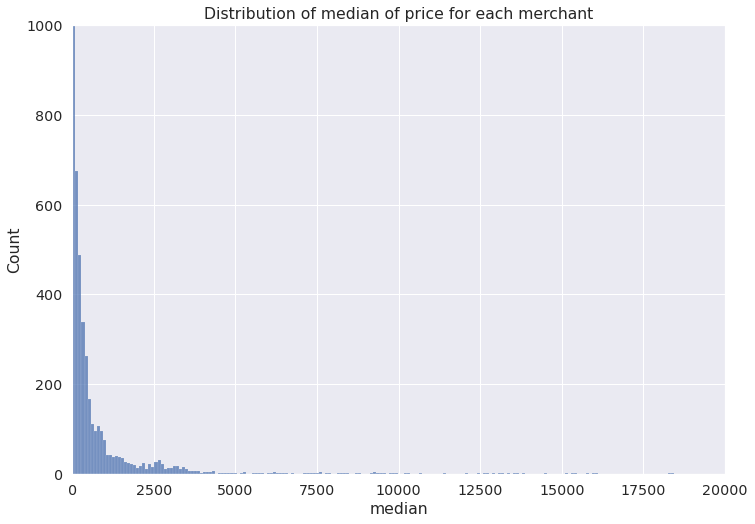

In [79]:
fig = sbs.histplot(cluster_df['median'])
fig.set_xlim(0, 20000)
fig.set_ylim(0, 1000)
fig.set_title("Distribution of median of price for each merchant")
fig = fig.get_figure()
fig.savefig('../plots/Distribution of median of price for each merchant.png')

In [80]:
cost = cleaned_sdf.select('dollar_value').toPandas()

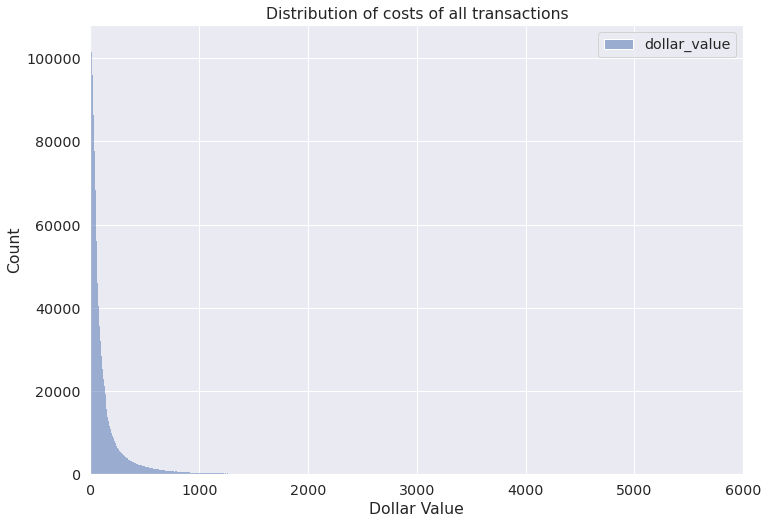

In [81]:
fig = sbs.histplot(cost)
fig.set_xlim(0, 6000)
fig.set_title("Distribution of costs of all transactions")
fig.set_xlabel('Dollar Value')
fig = fig.get_figure()
fig.savefig('../plots/Distribution of costs of all transactions.png')